<a href="https://colab.research.google.com/github/y001003/yeardream/blob/main/DL/torch/%ED%86%A0%EC%B9%98%EC%9D%98_%ED%98%B8%ED%9D%A1_Lesson_1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Model

## 1. Load Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn # class Model(nn.Module)
from torch.utils.data import Dataset, DataLoader
# Dataset, DataLoader
# df --> Dataset (X, y) --> DataLoader: Batch Size


In [2]:
ch = fetch_california_housing()

df = pd.DataFrame(ch.data, columns = ch.feature_names)
df['target'] = ch.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Dataset

학습할 컬럼과 타겟 컬럼을 잘라내고, 텐서로 반환한다.

In [3]:
class MyDataset(Dataset):
    def __init__(self, df = df):
        self.df = df
        self.x = self.df.iloc[:,:-1].values
        self.y = self.df.iloc[:,-1:].values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return torch.tensor(x, dtype = torch.float), torch.tensor(y, dtype = torch.float)

## 3. DataLoader

학습과 검증, 테스트 세트로 나눈다.

In [4]:
import os
num = os.cpu_count()

In [21]:
def MyLoaders(df = df,
              index = 20640,
              batch_size = 128):
    
    ratio = [0.6, 0.2, 0.2]
    train_cnt = int(index * ratio[0])
    valid_cnt = int(index * ratio[0] + index * ratio[1])
    # test_cnt = int(index * ratio[2])

    train = df.iloc[:train_cnt,:].reset_index(drop = True)
    valid = df.iloc[train_cnt:valid_cnt,:].reset_index(drop=True)
    test = df.iloc[valid_cnt:,:].reset_index(drop=True)

    train_ds = MyDataset(df = train) # return (x, y) tenser
    valid_ds = MyDataset(df = valid)
    test_ds = MyDataset(df = test)

    train_loader = DataLoader(train_ds,
                              batch_size = batch_size,
                              num_workers= num,
                              shuffle=True,
                              drop_last=True,
                              pin_memory = True)
    valid_loader = DataLoader(valid_ds,
                              batch_size = batch_size,
                              num_workers= num,
                              shuffle=False,
                              drop_last=False)
    test_loader = DataLoader(test_ds,
                              batch_size = batch_size,
                              num_workers= num,
                              shuffle=False,
                              drop_last=False)
    print("DataLoader train_valid_test split x,y")

    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = MyLoaders(df = df,
                                                    index = 20640,
                                                    batch_size = 128)

DataLoader train_valid_test split x,y


In [20]:
valid_loader

## 4. 모델 생성

### 4_1 Sequential 없이

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim = 8, output_dim = 1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4,2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2, output_dim)
    
    def forward(self, x):
        output = self.fc3(self.relu2(self.fc2(self.relu(self.fc1(x)))))
        return output

In [7]:
# 외우세여
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

## Colab -> GPU
model = Model(input_dim = 8, output_dim = 1).to(device)
model

Model(
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)

### 4_2 Sequential 사용

In [8]:
class Block(nn.Module):
    ## 이 동네(이 셀과 아래 셀)는 아직 안 배워서 모르실 수 있지만, 쉽게 말하면, 은닉층을 쌓는 과정 중 하나입니다. 
    def __init__(self, input_dim, output_dim, use_batchnorm = True, dropout_p=.3):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_batchnorm = use_batchnorm
        self.dropout_p =dropout_p

        # Normalization - 학습 방해요소를 넣어서 학습을 robust 하게 학습하도록 합니다.
        def get_regularizer(size, use_batchnorm):
            return nn.BatchNorm1d(size) if use_batchnorm else nn.Dropout(dropout_p)

        self.seq = nn.Sequential(
            nn.Linear(input_dim, output_dim), # 은닉층 구성
             nn.LeakyReLU(), # activation function
             get_regularizer(output_dim, use_batchnorm) # 위 함수 
        )

    def forward(self, x):
        return self.seq(x)

In [9]:
'''
class Model(nn.Module):
    # 위 클래스를 확인하면서 보세요 : )
    def __init__(self, input_dim, output_dim, use_batchnorm = True, dropout_p =.3):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_batchnorm = use_batchnorm
        self.dropout_p = dropout_p

        self.seq = nn.Sequential(
            # 은닉층의 노드, 활성화 함수, normalization 요소를 배치하면서 쌓는 과정입니다. 
            Block(input_dim = input_dim, output_dim = 7, use_batchnorm = True, ), 
            Block(input_dim = 7, output_dim = 5, use_batchnorm = True, ),##
            Block(input_dim = 5, output_dim = 3, use_batchnorm = True, ),
            Block(input_dim = 3, output_dim = 2, use_batchnorm = True, ),
            nn.Linear(2, output_dim)
        )

    def forward(self, x):
        return self.seq(x)
'''

'\nclass Model(nn.Module):\n    # 위 클래스를 확인하면서 보세요 : )\n    def __init__(self, input_dim, output_dim, use_batchnorm = True, dropout_p =.3):\n        super().__init__()\n        self.input_dim = input_dim\n        self.output_dim = output_dim\n        self.use_batchnorm = use_batchnorm\n        self.dropout_p = dropout_p\n\n        self.seq = nn.Sequential(\n            # 은닉층의 노드, 활성화 함수, normalization 요소를 배치하면서 쌓는 과정입니다. \n            Block(input_dim = input_dim, output_dim = 7, use_batchnorm = True, ), \n            Block(input_dim = 7, output_dim = 5, use_batchnorm = True, ),##\n            Block(input_dim = 5, output_dim = 3, use_batchnorm = True, ),\n            Block(input_dim = 3, output_dim = 2, use_batchnorm = True, ),\n            nn.Linear(2, output_dim)\n        )\n\n    def forward(self, x):\n        return self.seq(x)\n'

## 5. Run_train

In [10]:
# ## 개념도

# # 3. run_train
# for epoch in range(n_epochs):
#     # 1 epoch: 전체 데이터를 한 번 훑었을 때
#     # iteration: 전체 데이터 / Batch Size (예시: 2000 / 100 == 10) --> Model Update 횟수

#     # 1. train_one_epoch
#     train_loader -> train_loss -> Model 학습 O -> N번 만큼 모델이 업데이트

#     # 2. valid_one_epoch
#     valid_loader -> valid_loss -> Model 학습 X -> Only 성능 검증

#     # print_iter --> 주기적인 모니터링 

#     # Lowest Loss 갱신

#     # early_stop

In [11]:
## Loss Function, Optimizer
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),
                            #  lr = 1e-2 # Adam lr을 알아서 찾아가기 때문에 안 해줘도 상관은 없습니다.
                             )
## NLP AdamW -> lr = 1e-5, 5e-5

In [12]:
def train_one_epoch(model = model,
                    dataloader = train_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler = None
                    ):
    model.train()

    train_loss = 0
    max_norm = 5

    for data in dataloader:

        x_i = data[0].to(device)
        y_pred = model(x_i)
        y_true = data[1].to(device)

        loss = loss_fn(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        train_loss += float(loss)
    train_loss /= len(dataloader)

    return train_loss


In [19]:
@torch.no_grad()
def valid_one_epoch(model = model,
                    dataloader = valid_loader,
                    loss_fn = loss_fn
                    ):
    model.eval()

    valid_loss = 0

    with torch.no_grad():
        for data in dataloader:

            x_i = data[0].to(device)
            y_pred = model(x_i)
            y_true = data[1].to(device)

            loss = loss_fn(y_pred, y_true)
            
            valid_loss += float(loss)
    valid_loss /= len(dataloader)

    return valid_loss

In [14]:
import copy

In [15]:
def run_train(model = model,
              train_loader = train_loader,
              valid_loader = valid_loader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              scheduler = None,
              n_epochs = 200,
              print_iter = 20,
              early_stop = 30,
              best_model = None):
    
    train_history, valid_history = [], []

    lowest_loss = np.inf
    lowest_epoch = np.inf

    for epoch in range(n_epochs):
        # train one epoch
        train_loss = train_one_epoch(model = model,
                                    dataloader = train_loader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer,
                                    scheduler = None
                                    )
        # valid_one_epoch
        valid_loss = valid_one_epoch(model = model,
                                    dataloader = valid_loader,
                                    loss_fn = loss_fn
                                    )
        # loss 
        train_history.append(train_loss)
        valid_history.append(valid_loss)

        if (epoch + 1) % print_iter == 0:
            print("Epoch[%d]| TL=%.3e | VL=%.3e | LL=%.3e" % (epoch +1, train_loss, valid_loss, lowest_loss))
        
        if lowest_loss > valid_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch

            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), './model.bin')
        
        else:
            if early_stop >0 and lowest_epoch + early_stop < epoch + 1:
                print("early stop")
                break
        
    print("The Best Validation Loss=%.3e at %d Epoch" % (lowest_loss, lowest_epoch))

    model.load_state_dict(best_model)

    return model, train_history, valid_history


In [22]:
model, train_history, valid_history = run_train(model = model,
                                        train_loader = train_loader,
                                        valid_loader = valid_loader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer,
                                        scheduler = None,
                                        n_epochs = 200,
                                        print_iter = 20,
                                        early_stop = 30,
                                        best_model = None)

Epoch[20]| TL=5.749e-01 | VL=6.136e-01 | LL=6.672e-01
Epoch[40]| TL=5.214e-01 | VL=5.982e-01 | LL=5.957e-01
early stop
The Best Validation Loss=5.957e-01 at 28 Epoch


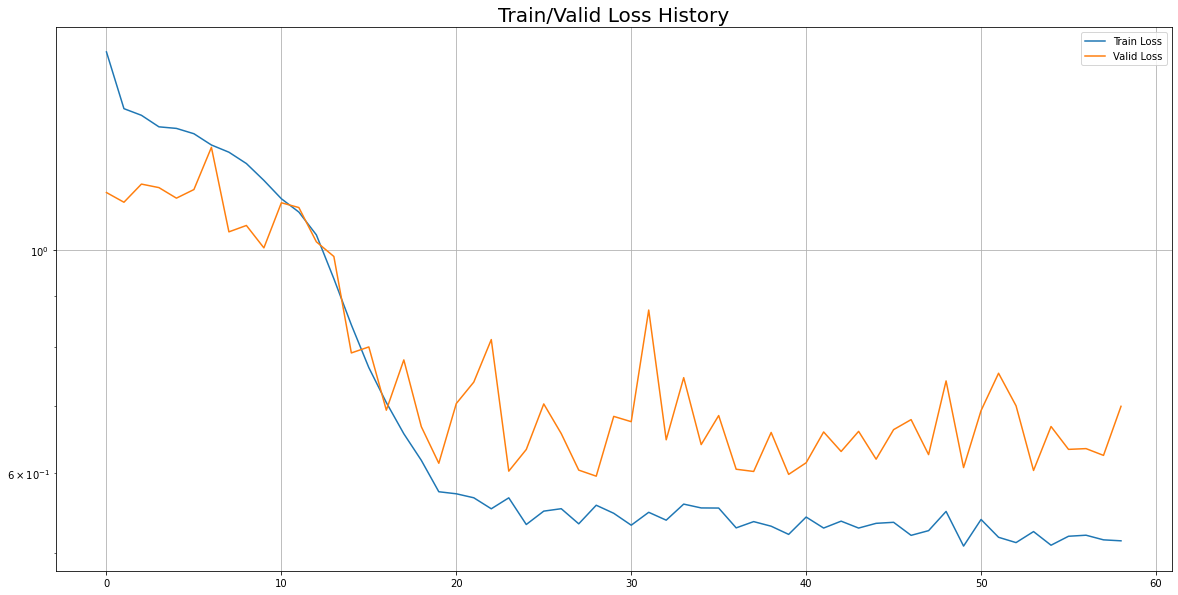

In [23]:
# train_loss, validation loss 추이 시각화
plot_from = 0
plt.figure(figsize = (20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)

plt.plot(range(0, len(train_history[plot_from:])), train_history[plot_from:], label ="Train Loss")
plt.plot(range(0, len(valid_history[plot_from:])), valid_history[plot_from:], label ="Valid Loss")

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()